# Getting Started


Here we go through a complete rocket trajectory simulation to get you started.

Also, a more in detail complete description of the simulation can also be found in the [First Simulation Section of the RocketPy Documentation](https://docs.rocketpy.org/en/latest/user/first_simulation.html).

If you want, you can open this notebook in Google Colab by clicking the badge below.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RocketPy-Team/rocketpy/blob/master/docs/notebooks/getting_started_colab.ipynb)

Let's start by importing the rocketpy module.


In [166]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
from rocketpy import Environment, Flight, Rocket, SolidMotor

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


In [168]:
%matplotlib widget

## Setting Up a Simulation


### Creating an Environment for Spaceport America

The `Environment` class is used to define the atmosphere, the winds, and the gravity models.

You can find more information about the `Environment` class in the [Environment Class Usage Docs](https://docs.rocketpy.org/en/latest/notebooks/environment/environment_class_usage.html).


In [169]:
env = Environment(latitude=54.303428, longitude=-5.583783, elevation=30) # Bishopscourt Racetrack, 29 Lismore Rd, Downpatrick BT30 7SY

To get weather data from the GFS forecast, available online, we run the following lines.

First, we set tomorrow's date.


In [170]:
import datetime

# tomorrow = datetime.date.today() + datetime.timedelta(days=14)
launchDay = (2025, 11, 22, 11)

env.set_date(
    # (tomorrow.year, tomorrow.month, tomorrow.day, 11)
    launchDay
)

Then, we tell env to use a GFS forecast to get the atmospheric conditions for flight.

Don't mind the warning, it just means that not all variables, such as wind speed or atmospheric temperature, are available at all altitudes given by the forecast.


In [171]:
env.set_atmospheric_model(type="Forecast", file="GFS")

c:\Users\igork\OneDrive\Documents\Code\L1 High Power Rocket Simulation Nov 2025\.venv\lib\site-packages\rocketpy\environment\tools.py:309: UserWarning: Exact chosen launch time is not available in the provided file, using 2025-11-22 12:00:00 UTC instead.
  warnings.warn(


We can see what the weather will look like by calling the info method!



Gravity Details

Acceleration of gravity at surface level:    9.8144 m/s²
Acceleration of gravity at   1.100 km (ASL): 9.8111 m/s²


Launch Site Details

Launch Date: 2025-11-22 11:00:00 UTC
Launch Site Latitude: 54.30343°
Launch Site Longitude: -5.58378°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 331886.41 W    6020361.35 N
Launch Site UTM zone: 30U
Launch Site Surface Elevation: 17.1 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 1.100 km
Forecast Time Period: from 2025-11-11 12:00:00 to 2025-11-27 12:00:00 utc
Forecast Hour Interval: 3 hrs
Forecast Latitude Range: From -90.0° to 90.0°
Forecast Longitude Range: From 0.0° to 359.75°

Surface Atmospheric Conditions

Surface Wind Speed: 5.60 m/s
Surface Wind Direction: 208.26°
Surface Wind Heading: 28.26°
Surface Pressure: 1000.00 hPa
Surface Temperature: 280.08 K
Surface Air Density: 1.244 kg/m³
Surface Speed of Sound: 335.49 m/s


Earth Model Details

Earth Radius at Launch site

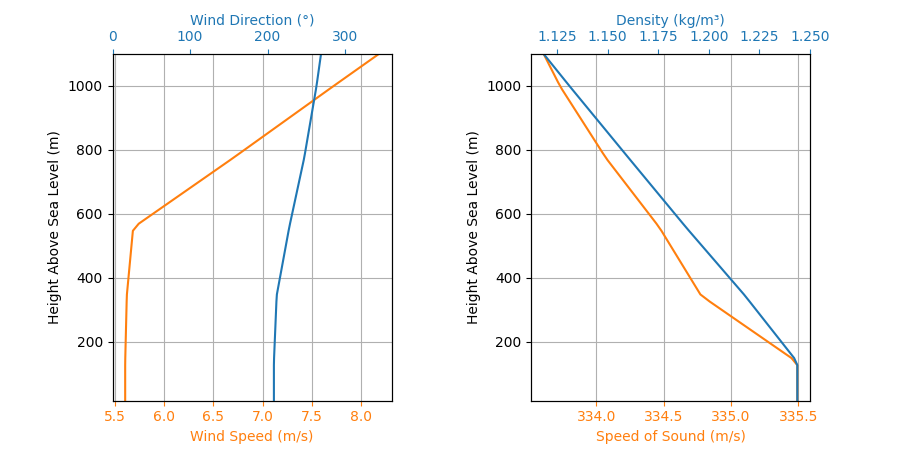

In [172]:
env.max_expected_height = 1100  # adjust the plots to this height
env.info()

### Creating a Motor

A solid rocket motor is used in this case. To create a motor, the SolidMotor class is used and the required arguments are given.

The SolidMotor class requires the user to have a thrust curve ready. This can come either from a .eng file for a commercial motor, such as below, or a .csv file from a static test measurement.

Besides the thrust curve, other parameters such as grain properties and nozzle dimensions must also be given.

See [Solid Motor Class Usage Docs](https://docs.rocketpy.org/en/latest/user/motors/solidmotor.html) for more information.


In [173]:
# IMPORTANT: modify the file path below to match your own system

AeroTechHPH195NT = SolidMotor(
    thrust_source="data\motors\AeroTech_HP-H195NT.eng",
    dry_mass=0.115,# kg
    dry_inertia=(0.01, 0.01, 0.002),#
    nozzle_radius=14.5 / 1000,# m
    grain_number=1,#
    grain_density=1815, # kg/m^3
    grain_outer_radius=14.5 / 1000,# m
    grain_initial_inner_radius=10 / 1000,# m
    grain_initial_height=180 / 1000,# m
    grain_separation=0,#
    grains_center_of_mass_position=0.1,#
    center_of_dry_mass_position=0.1,#
    nozzle_position=0,#
    burn_time=1.16,#
    throat_radius=14.5 / 1000,#
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

**Pay special attention to _position_ related parameters:**
More details on [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)


To see what our thrust curve looks like, along with other import properties, we invoke the info method yet again. You may try the all_info method if you want more information all at once!


Nozzle Details
Nozzle Radius: 0.0145 m
Nozzle Throat Radius: 0.0145 m

Grain Details
Number of Grains: 1
Grain Spacing: 0 m
Grain Density: 1815 kg/m3
Grain Outer Radius: 0.0145 m
Grain Inner Radius: 0.01 m
Grain Height: 0.18 m
Grain Volume: 0.000 m3
Grain Mass: 0.113 kg

Motor Details
Total Burning Time: 1.16 s
Total Propellant Mass: 0.113 kg
Structural Mass Ratio: 0.504
Average Propellant Exhaust Velocity: 2092.844 m/s
Average Thrust: 204.153 N
Maximum Thrust: 256.571 N at 0.019 s after ignition.
Total Impulse: 236.818 Ns



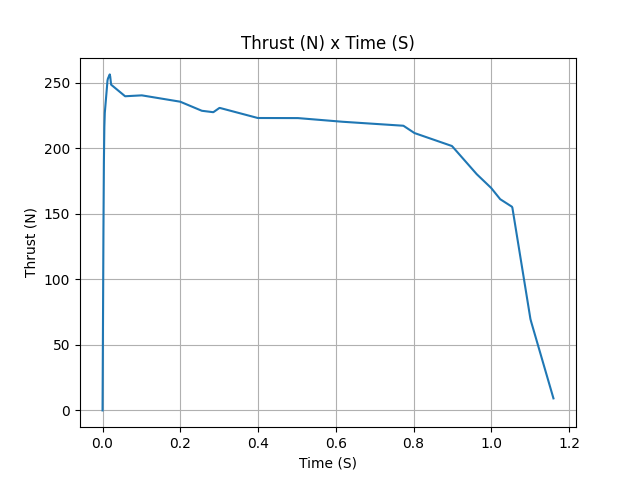

In [174]:
AeroTechHPH195NT.info()

### Creating a Rocket


A rocket is composed of several components. Namely, we must have a motor (good thing we have the AeroTech_HP-H195NT ready), a couple of aerodynamic surfaces (nose cone, fins and tail) and parachutes (if we are not launching a missile).

You can find more information about the `Rocket` class in the [Rocket Class Usage Docs](https://docs.rocketpy.org/en/latest/user/rocket.html).

Let's start by initializing our rocket, named TexasL1, entering inertia properties, some dimensions and drag curves.

**Pay special attention to _position_ related parameters:**
More details on [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)


In [175]:
TexasL1 = Rocket(
    radius=33.25 / 1000,
    mass=0.65,
    inertia=(0.13, 0.13, 0.00056),
    power_off_drag="data\drag coeff\TexasL1 time drag coefficient.csv",
    power_on_drag="data\drag coeff\TexasL1 time drag coefficient.csv",
    center_of_mass_without_motor=0.622,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = TexasL1.set_rail_buttons(
    upper_button_position=0.15,
    lower_button_position=0.05,
    angular_position=45,
)

To add the motor to our rocket we need only inform what motor we are adding (AeroTech_HP-H195NT) and inform the position, in meters, of the motor's nozzle exit area relative to the previously defined coordinate system.


In [176]:
TexasL1.add_motor(AeroTechHPH195NT, position=0)

#### Adding Aerodynamic Surfaces


Now we define the aerodynamic surfaces. They are really straight forward with special attention needed only for the position values. Here is a quick guide:

- The positions given **must** be relative to the same coordinate system as the rockets;
- Position of the Nosecone refers to the tip of the nose;
- Position of fins refers to the point belonging to the root chord which is highest in the rocket coordinate system;
- Position of the tail the point belonging to the tail which is highest in the rocket coordinate system.

See more details in [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)


In [177]:
nose_cone = TexasL1.add_nose(length=0.23, kind="ogive", position=0.915+0.23)

fin_set = TexasL1.add_trapezoidal_fins(
    n=3,
    root_chord=0.16,
    tip_chord=0.085,
    span=0.05,
    position=0.16,
    cant_angle=0,
)

To see all information regarding the rocket we just defined we run:



Inertia Details

Rocket Mass: 0.650 kg (without motor)
Rocket Dry Mass: 0.765 kg (with unloaded motor)
Rocket Loaded Mass: 0.878 kg
Rocket Structural Mass Ratio: 0.871
Rocket Inertia (with unloaded motor) 11: 0.167 kg*m2
Rocket Inertia (with unloaded motor) 22: 0.167 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.003 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.03325 m
Rocket Frontal Area: 0.003473 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.078 m
Rocket Center of Dry Mass - Nozzle Exit: 0.544 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.444 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.057 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 4.472/rad

Center of Pressure

Nose 

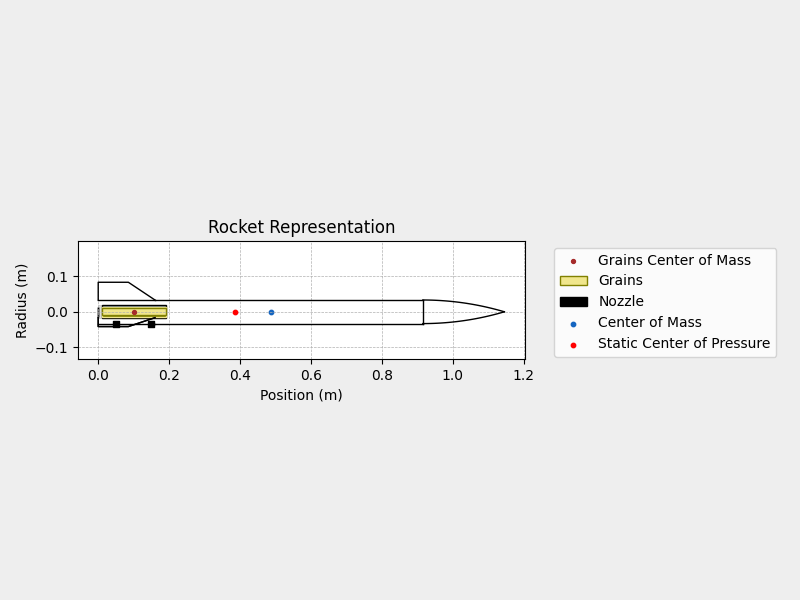


Mass Plots
----------------------------------------


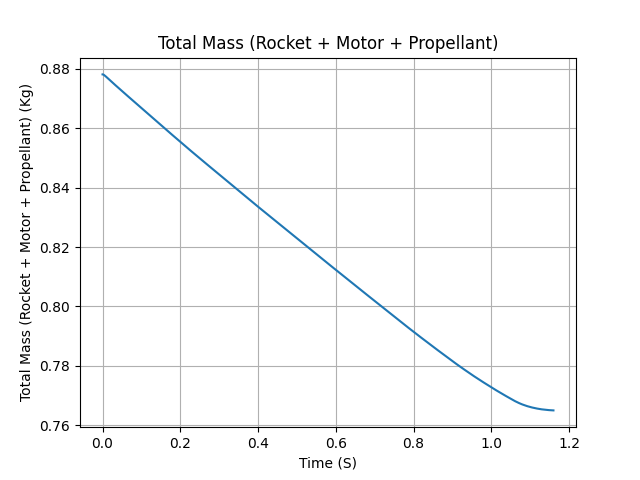

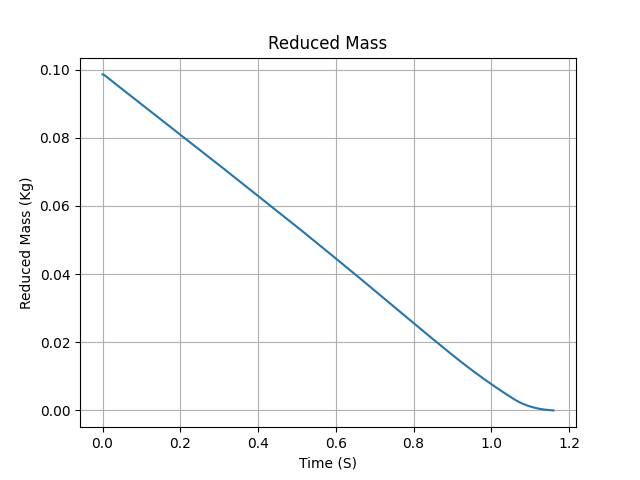


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


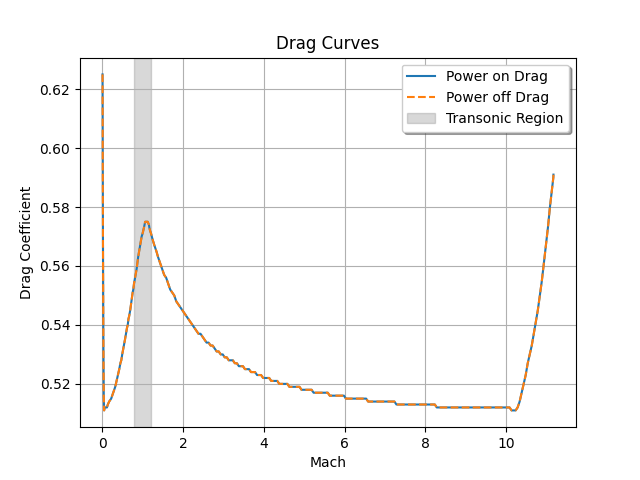


Stability Plots
--------------------


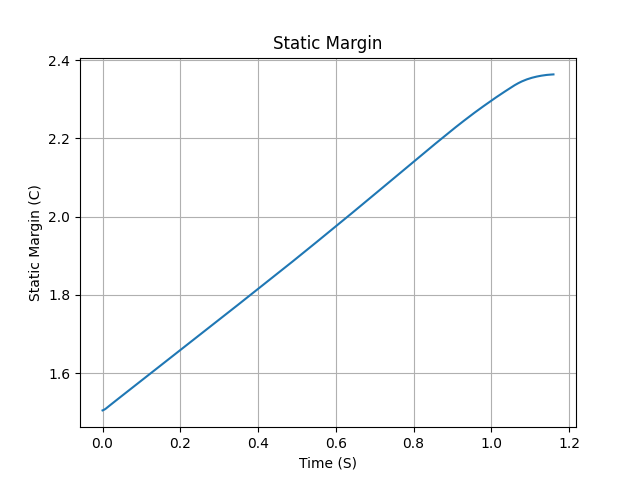

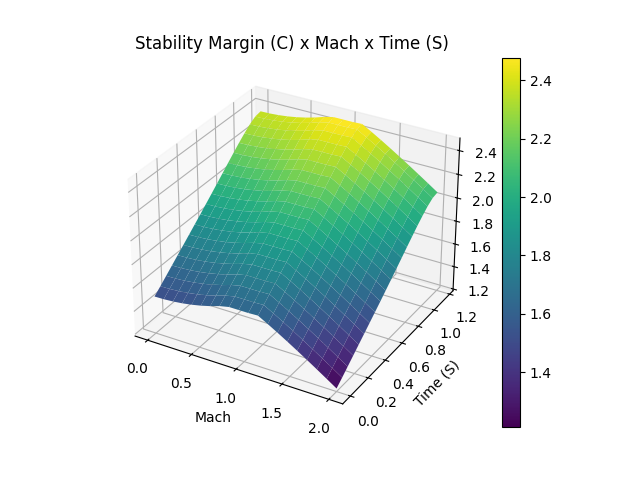


Thrust-to-Weight Plot
----------------------------------------


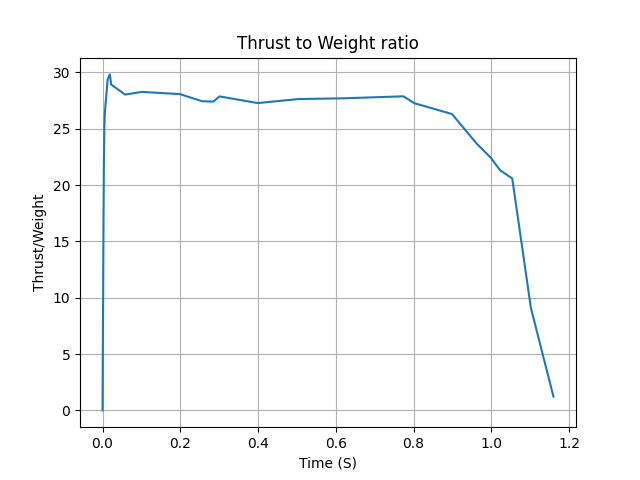

In [178]:
TexasL1.all_info()

#### Adding Parachutes


Finally, we have parachutes! TexasL1 will have two parachutes, Drogue and Main. The Drogue parachute will open at apogee while the Main parachute will open at 800m above ground level

For more details see [Adding Parachutes](https://docs.rocketpy.org/en/latest/user/rocket.html#adding-parachutes)


In [ ]:
# 24" X Foil
Drogue = TexasL1.add_parachute(
    "Main",
    cd_s=0.24, # 0.2-1.0 approx. assume worst case
    trigger="apogee",
    lag=14
)

Just be careful if you run this last cell multiple times! If you do so, your rocket will end up with lots of parachutes which activate together, which may cause problems during the flight simulation. We advise you to re-run all cells which define our rocket before running this, preventing unwanted old parachutes. Alternatively, you can run the following lines to remove parachutes.

```python
TexasL1.parachutes.remove(Drogue)
TexasL1.parachutes.remove(Main)
```


## Simulating a Flight

Simulating a flight trajectory is as simple as initializing a Flight class object givin the rocket and environnement set up above as inputs. The launch rail inclination and heading are also given here.


In [180]:
test_flight = Flight(
    rocket=TexasL1, environment=env, rail_length=5.2, inclination=87, heading=0
)

## Analyzing the Results

RocketPy gives you many plots, thats for sure! They are divided into sections to keep them organized. Alternatively, see the Flight class documentation to see how to get plots for specific variables only, instead of all of them at once.



Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 17.11 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.924 | e1: -0.024 | e2: 0.010 | e3: 0.383
Euler Angles - Spin φ : 45.00° | Nutation θ: -3.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 1.504 c


Surface Wind Conditions

Frontal Surface Wind Speed: 4.93 m/s
Lateral Surface Wind Speed: -2.65 m/s


Launch Rail

Launch Rail Length: 5.2 m
Launch Rail Inclination: 87.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.197 s
Rail Departure Velocity: 51.728 m/s
Rail Departure Stability Margin: 1.660 c
Rail Departure Angle of Attack: 6.205°
Rail Departure Thrust-Weight Ratio: 28.080
Rail Departure Reynolds Number: 2.447e+05


Burn out State

Burn out time: 1.160 s
Altitude at burn out: 178.052 m (ASL) | 160.944 m (AGL)
Rocket speed at burn out: 234.973 m/s
Freestream velocit

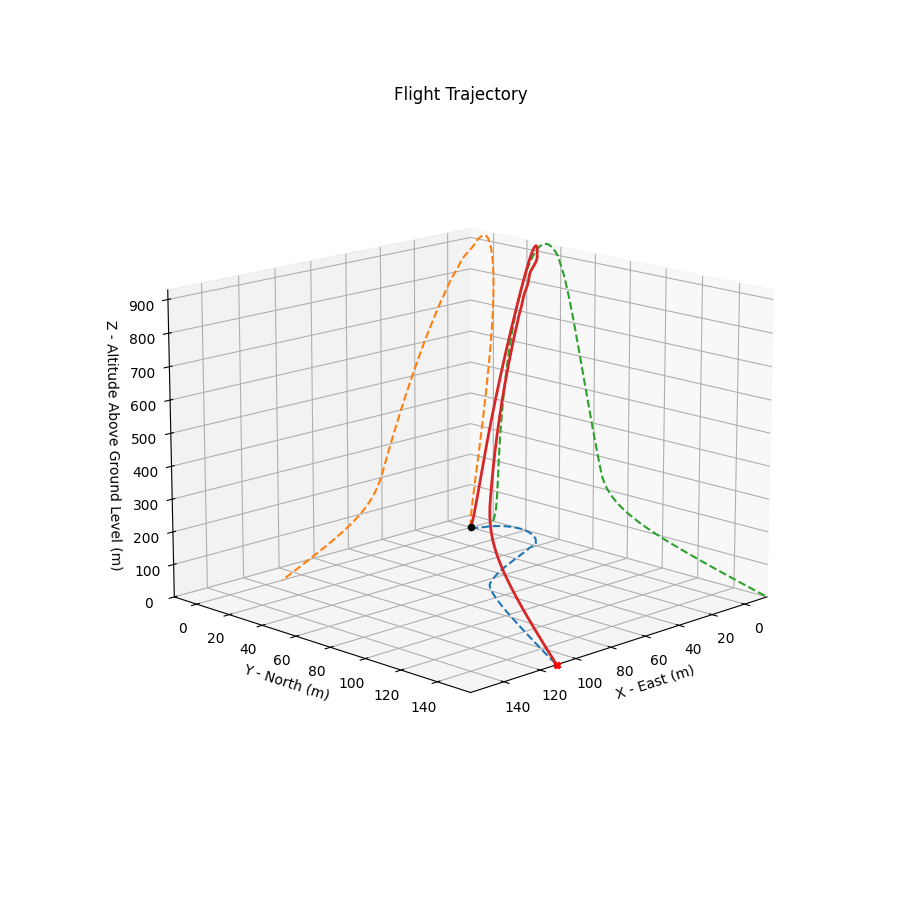



Trajectory Kinematic Plots



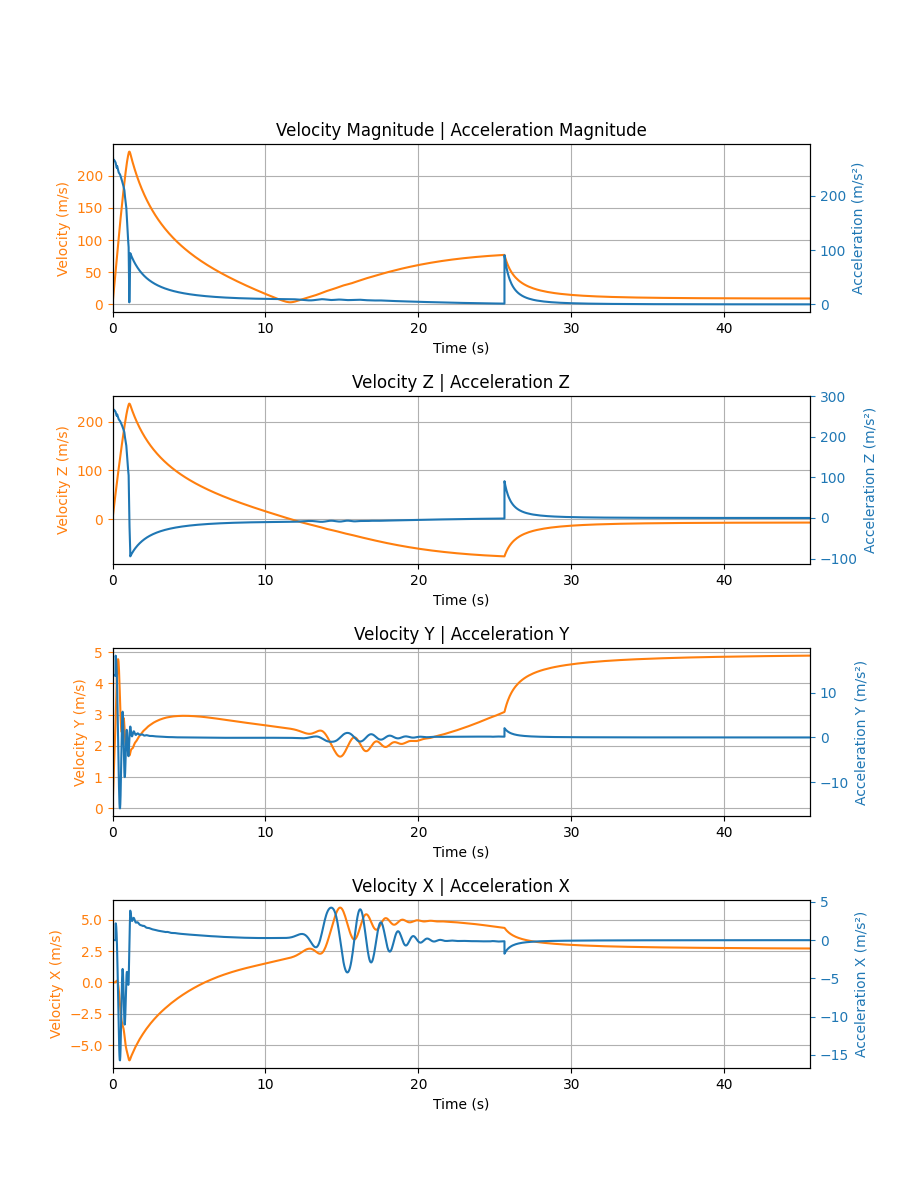



Angular Position Plots



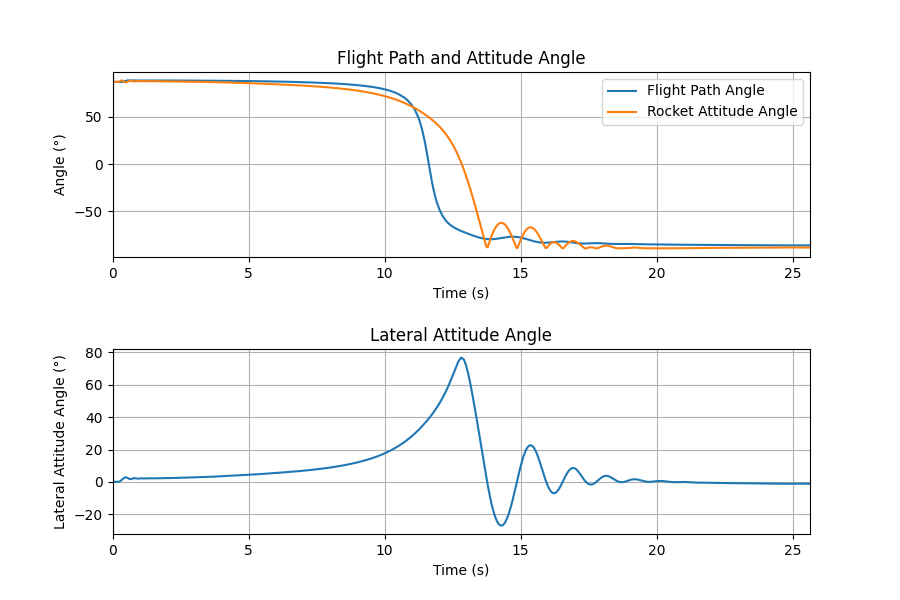



Path, Attitude and Lateral Attitude Angle plots



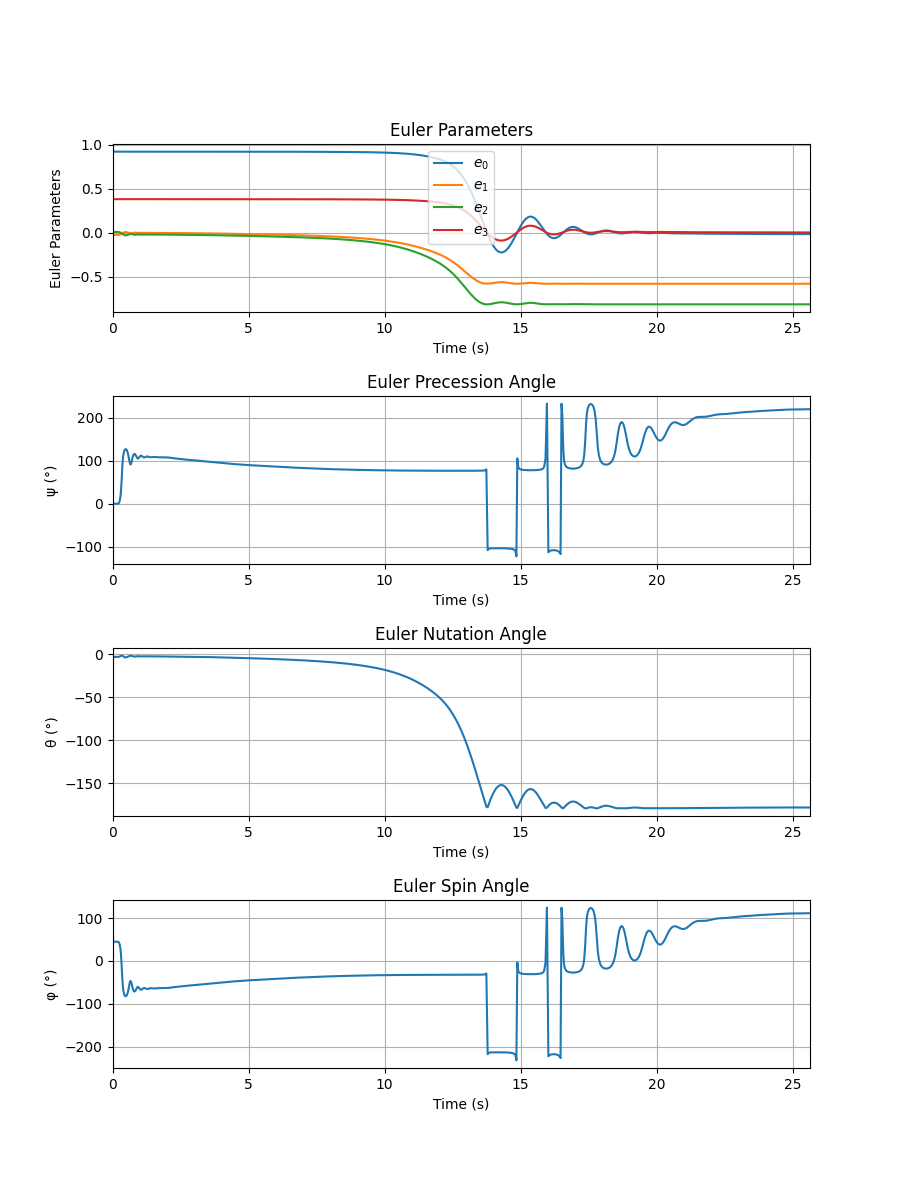



Trajectory Angular Velocity and Acceleration Plots



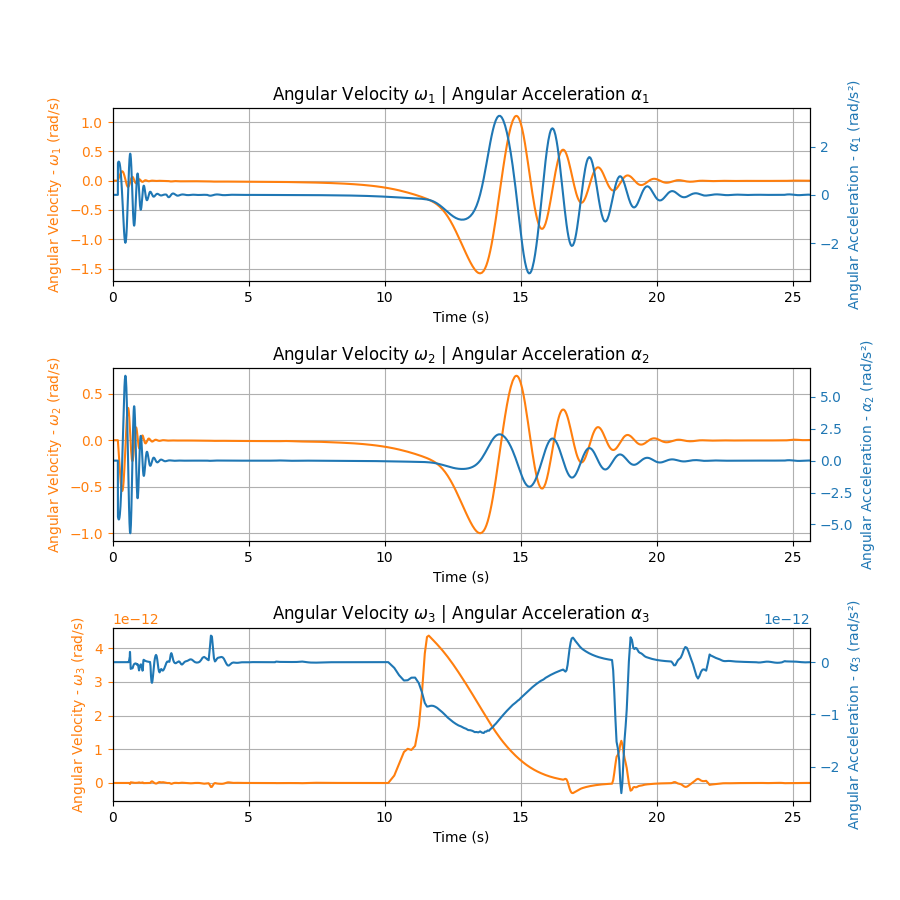



Aerodynamic Forces Plots



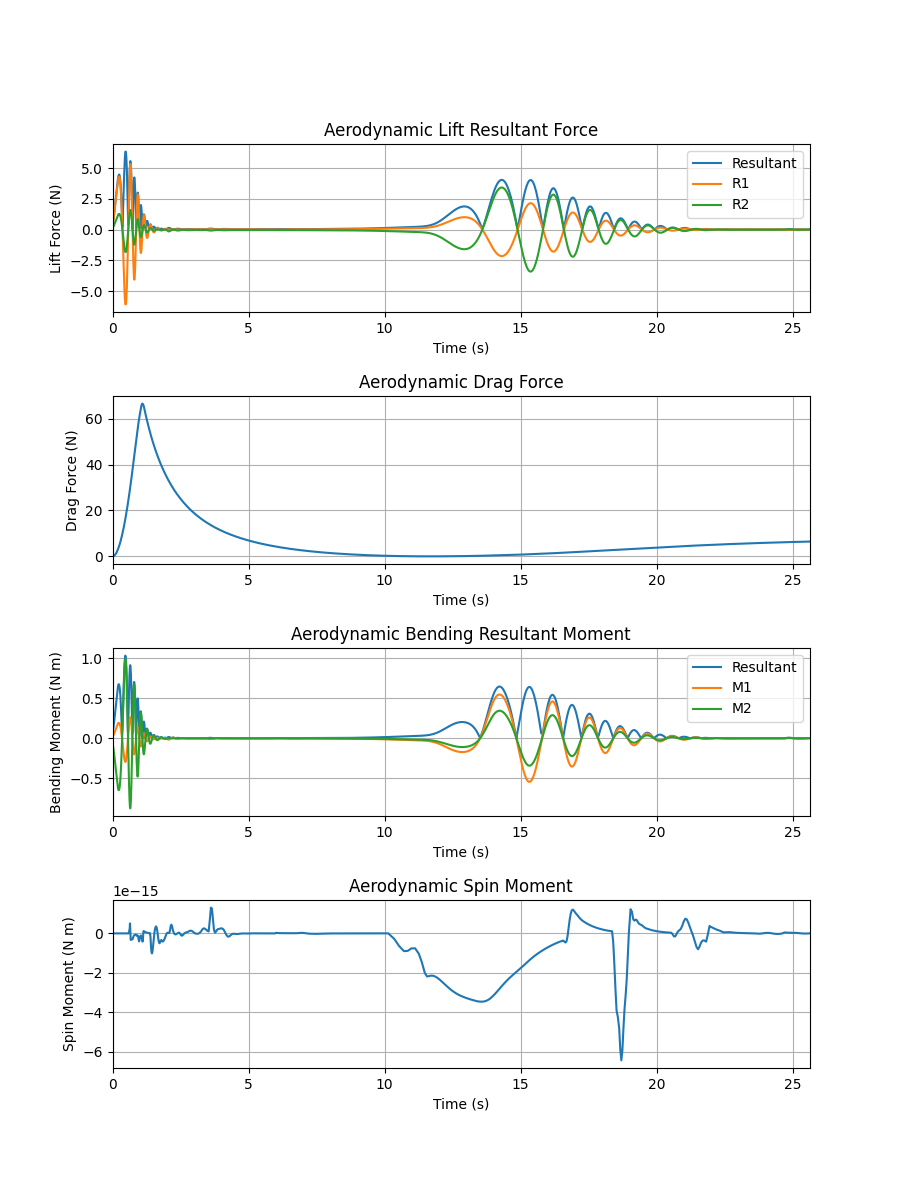



Rail Buttons Forces Plots



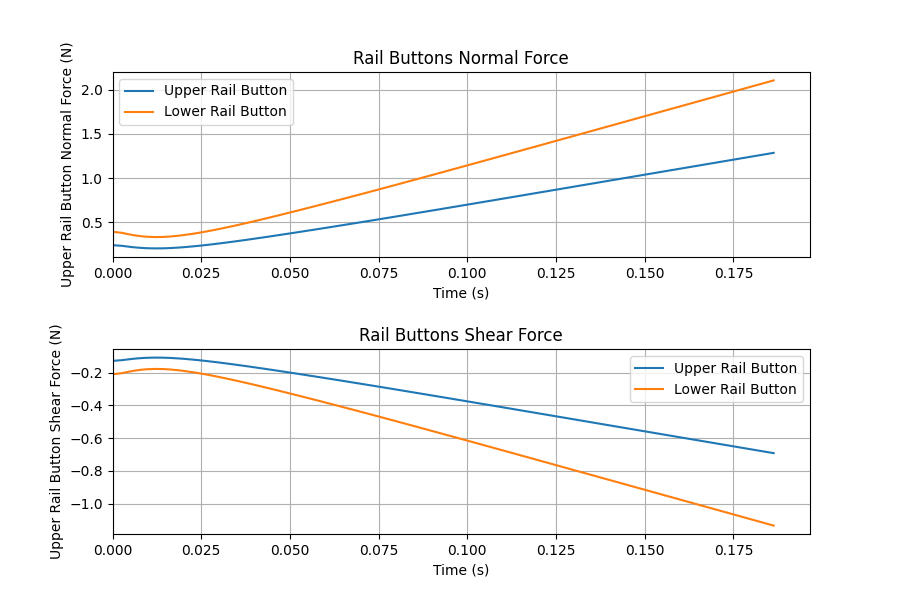



Trajectory Energy Plots



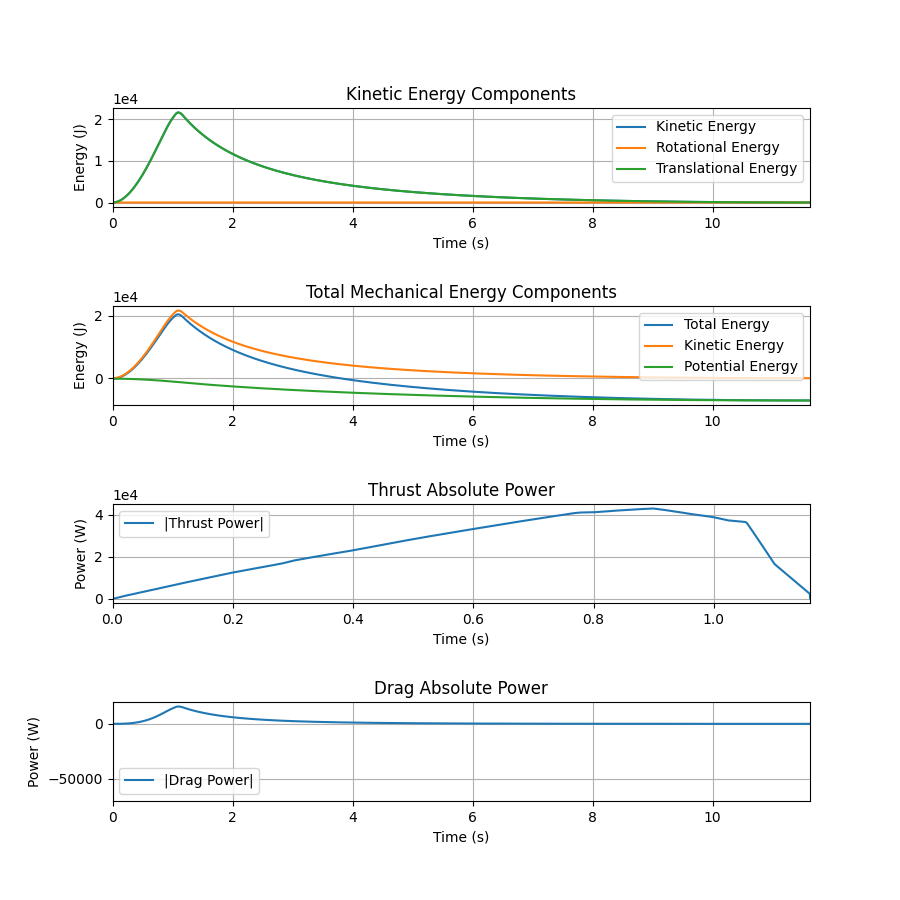



Trajectory Fluid Mechanics Plots



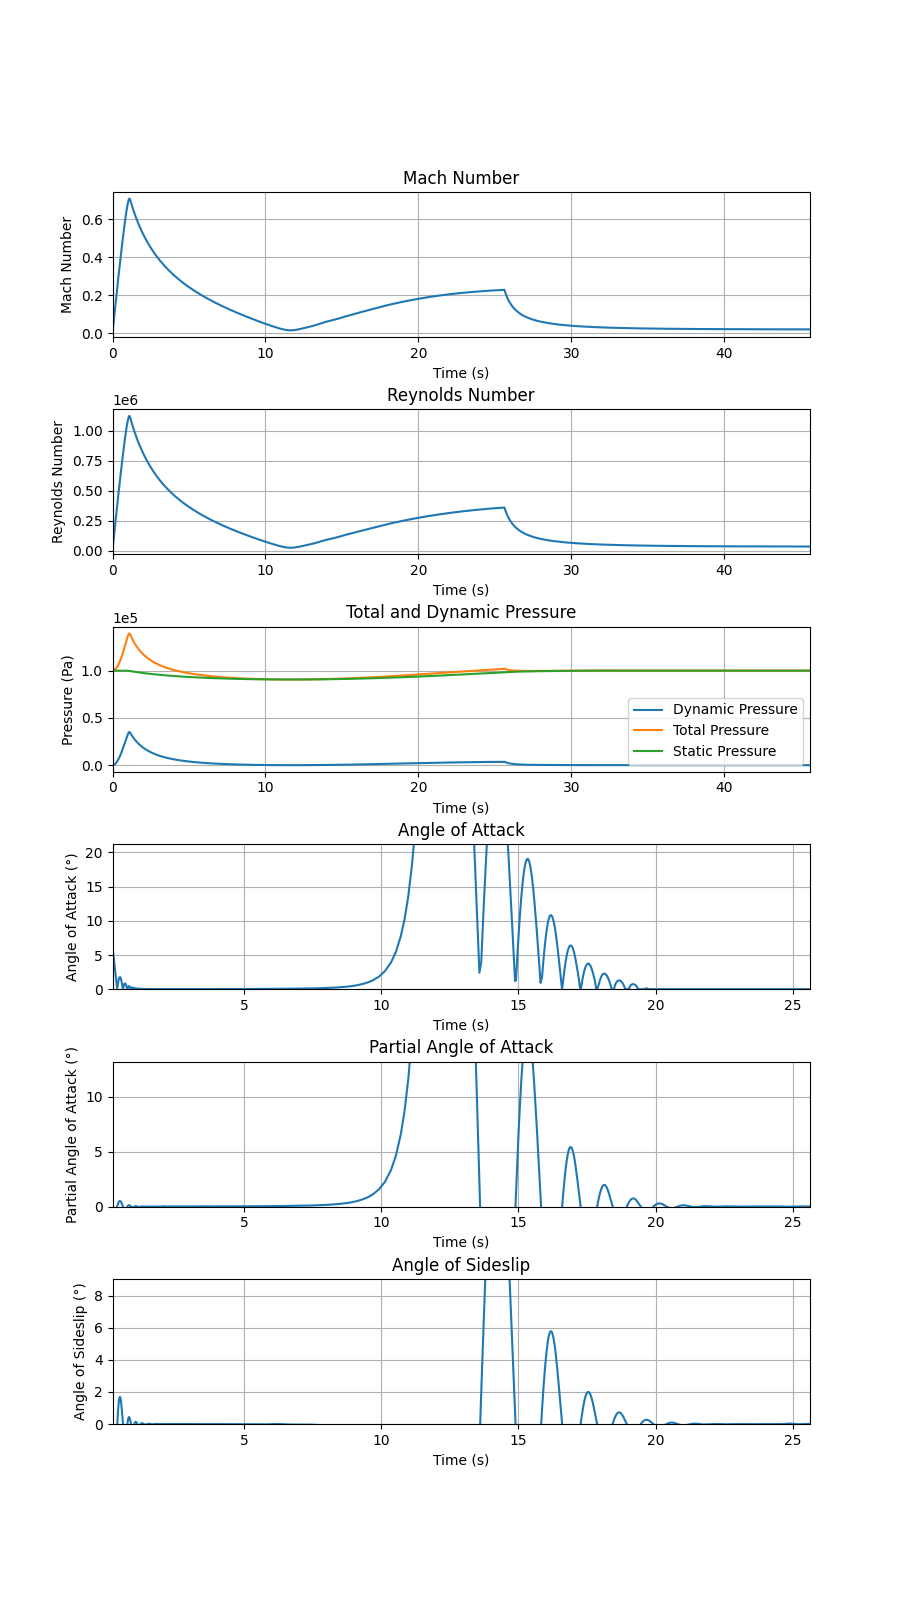



Trajectory Stability and Control Plots



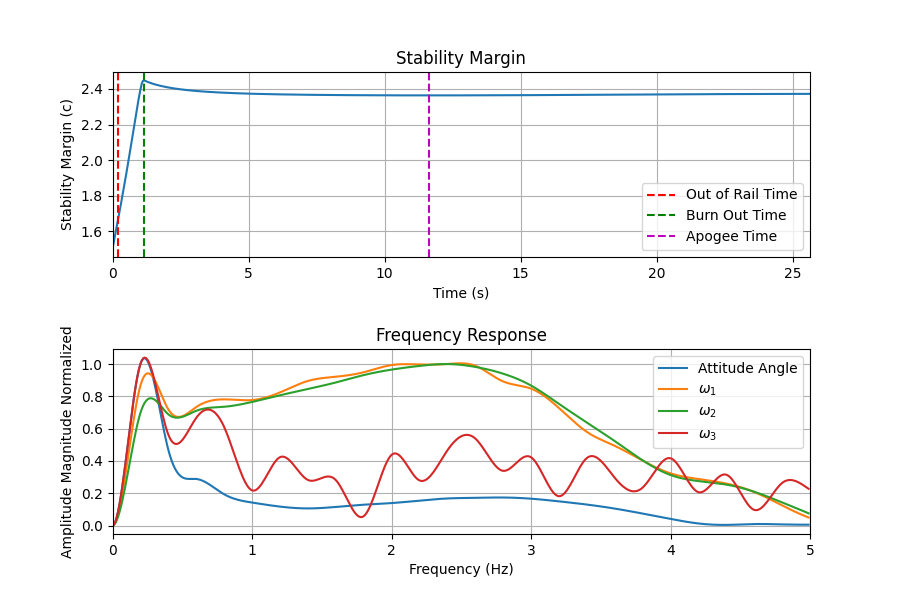



Rocket and Parachute Pressure Plots



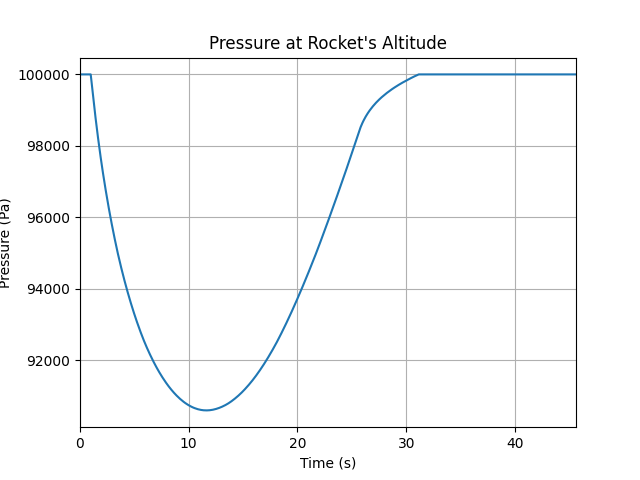


Parachute:  Main


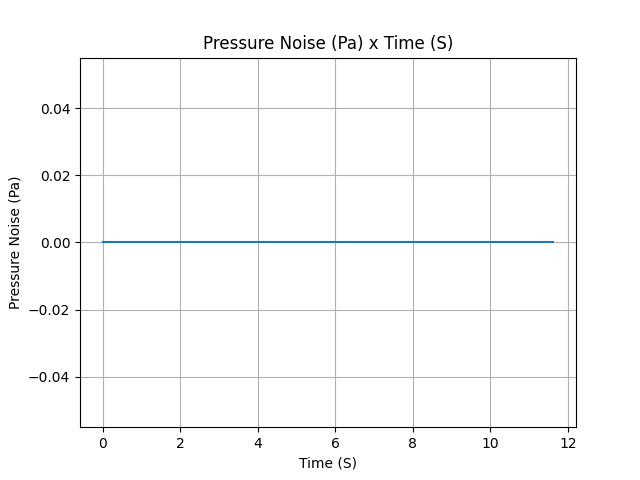

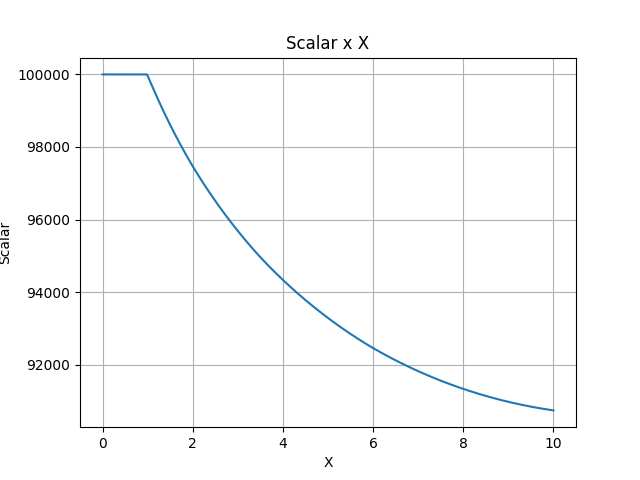

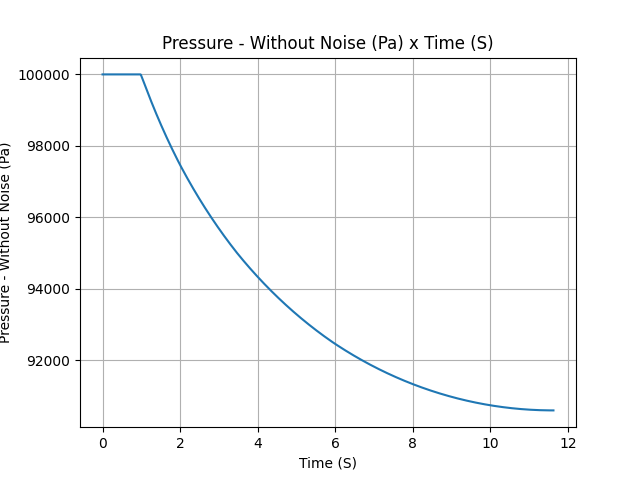

In [181]:
test_flight.all_info()

In [182]:
# 1. Retrieve time of impact via prints
test_flight.prints.impact_conditions()

# 2. Get altitude and time of apogee (top of flight)
test_flight.prints.apogee_conditions()

# 3. Compute average descent rate (approximate)
t_apogee = test_flight.apogee_time      # Time when vertical velocity becomes zero
h_apogee = test_flight.apogee           # Altitude at apogee
t_impact = test_flight.t_final          # From docs for Flight: “Time of Impact” shows as t_final in prints. :contentReference[oaicite:3]{index=3}
h_impact = test_flight.z(t_impact)      # Altitude at impact time

descent_time = t_impact - t_apogee
descent_distance = h_apogee - h_impact
avg_descent_rate = descent_distance / descent_time
print(f"Average descent rate ≈ {avg_descent_rate:.2f} m/s downward")

# 4. Compute instantaneous descent rate at impact
vz_impact = test_flight.vz(t_impact)   # negative value
inst_descent_rate = abs(vz_impact)
print(f"Instantaneous descent rate at impact ≈ {inst_descent_rate:.2f} m/s")


Impact Conditions

Time of impact: 45.609 s
X impact: 110.833 m
Y impact: 157.973 m
Altitude impact: 17.108 m (ASL) | 0.000 m (AGL) 
Latitude: 54.3048502°
Longitude: -5.5820728°
Vertical velocity at impact: -7.233 m/s
Number of parachutes triggered until impact: 1

Apogee State

Apogee Time: 11.622 s
Apogee Altitude: 945.391 m (ASL) | 928.283 m (AGL)
Apogee Freestream Speed: 5.484 m/s
Apogee X position: -7.797 m
Apogee Y position: 31.723 m
Apogee latitude: 54.3037136°
Apogee longitude: -5.5839033°
Average descent rate ≈ 27.31 m/s downward
Instantaneous descent rate at impact ≈ 7.23 m/s


In [183]:
print(launchDay)

(2025, 11, 22, 11)


Export Flight Trajectory to a .kml file so it can be opened on Google Earth


In [184]:
test_flight.export_kml(
    file_name=f"data/flights/trajectoryTexasL1_{launchDay[0]:04}{launchDay[1]:02}{launchDay[2]:02}-{launchDay[3]:02}_"+datetime.date.today().strftime("%Y%m%d")+".kml",
    extrude=True,
    altitude_mode="relative_to_ground",
)

File  data/flights/trajectoryTexasL1_20251122-11_20251111.kml  saved with success!


C:\Users\igork\AppData\Local\Temp\ipykernel_55792\3073933146.py:1: DeprecationWarning: Moved to FlightDataExporter.export_kml() and will be removed in v1.12.0. Use `rocketpy.simulation.flight_data_exporter.FlightDataExporter.export_kml` instead.
  test_flight.export_kml(


## Using Simulation for Design

Here, we go through a couple of examples which make use of RocketPy in cool ways to help us design our rocket.


### Apogee as a Function of Mass

This one is a classic one! We always need to know how much our rocket's apogee will change when our payload gets heavier.


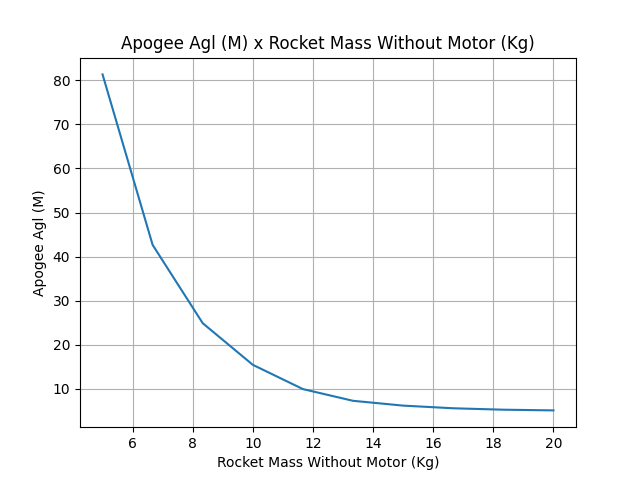

'Function from R1 to R1 : (Rocket Mass without motor (kg)) → (Apogee AGL (m))'

In [185]:
from rocketpy.utilities import apogee_by_mass

apogee_by_mass(flight=test_flight, min_mass=5, max_mass=20, points=10, plot=True)

### Out of Rail Speed as a Function of Mass

Lets make a really important plot. Out of rail speed is the speed our rocket has when it is leaving the launch rail. This is crucial to make sure it can fly safely after leaving the rail. A common rule of thumb is that our rocket's out of rail speed should be 4 times the wind speed so that it does not stall and become unstable.


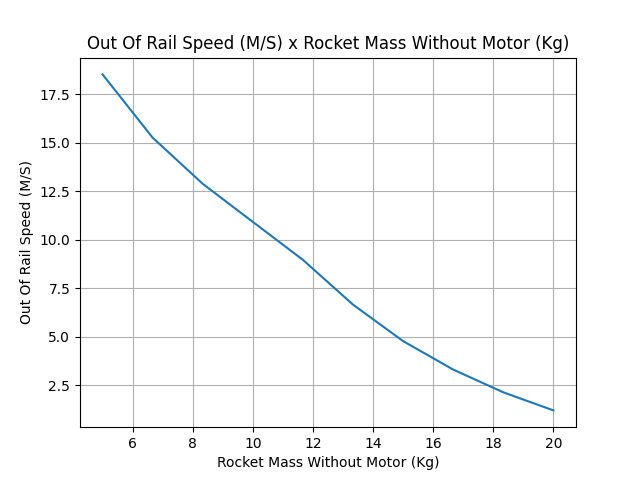

'Function from R1 to R1 : (Rocket Mass without motor (kg)) → (Out of Rail Speed (m/s))'

In [186]:
from rocketpy.utilities import liftoff_speed_by_mass

liftoff_speed_by_mass(flight=test_flight, min_mass=5, max_mass=20, points=10, plot=True)

### Dynamic Stability Analysis

Ever wondered how static stability translates into dynamic stability? Different static margins result in different dynamic behavior, which also depends on the rocket's rotational inertial.

Let's make use of RocketPy's helper class called Function to explore how the dynamic stability of TexasL1 varies if we change the fins span by a certain factor.


Simulating Rocket with Static Margin of 1.295->1.339 c
Current Simulation Time: 4.5986 s
>>> Simulation Completed at Time: 4.5942 s
Simulating Rocket with Static Margin of 5.529->5.572 c
Current Simulation Time: 4.5999 s
>>> Simulation Completed at Time: 4.5942 s
Simulating Rocket with Static Margin of 9.762->9.806 c
Current Simulation Time: 4.5949 s
>>> Simulation Completed at Time: 4.5942 s
Simulating Rocket with Static Margin of 13.996->14.039 c
Current Simulation Time: 4.6037 s
>>> Simulation Completed at Time: 4.5942 s
Simulating Rocket with Static Margin of 18.229->18.273 c
Current Simulation Time: 4.6031 s
>>> Simulation Completed at Time: 4.5942 s


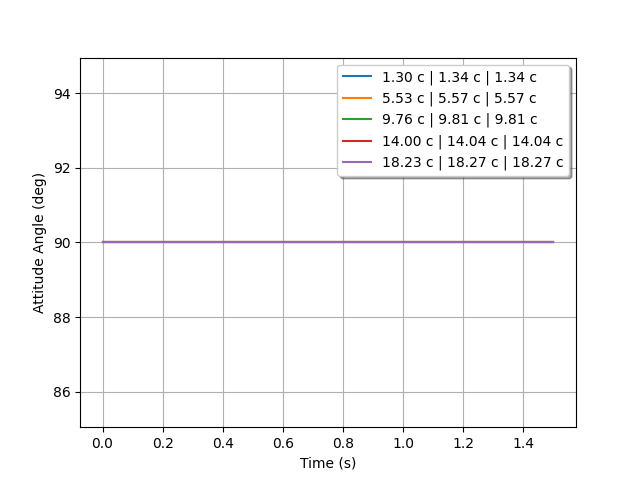

In [187]:
# Helper class
import copy

from rocketpy import Function

# Prepare a copy of the rocket
TexasL12 = copy.deepcopy(TexasL1)

# Prepare Environment Class
custom_env = Environment()
custom_env.set_atmospheric_model(type="custom_atmosphere", wind_v=-5)

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [-0.5, -0.2, 0.1, 0.4, 0.7]:
    # Modify rocket fin set by removing previous one and adding new one
    TexasL12.aerodynamic_surfaces.pop(-1)

    fin_set = TexasL12.add_trapezoidal_fins(
        n=4,
        root_chord=0.120,
        tip_chord=0.040,
        span=0.100,
        position=-1.04956 * factor,
    )
    # Simulate
    print(
        "Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c".format(
            TexasL12.static_margin(0),
            TexasL12.static_margin(TexasL12.motor.burn_out_time),
        )
    )
    test_flight = Flight(
        rocket=TexasL12,
        environment=custom_env,
        rail_length=5.2,
        inclination=90,
        heading=0,
        max_time_step=0.01,
        max_time=5,
        terminate_on_apogee=True,
        verbose=True,
    )
    # Store Results
    static_margin_at_ignition = TexasL12.static_margin(0)
    static_margin_at_out_of_rail = TexasL12.static_margin(test_flight.out_of_rail_time)
    static_margin_at_steady_state = TexasL12.static_margin(test_flight.t_final)
    simulation_results += [
        (
            test_flight.attitude_angle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                static_margin_at_ignition,
                static_margin_at_out_of_rail,
                static_margin_at_steady_state,
            ),
        )
    ]

Function.compare_plots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

### Characteristic Frequency Calculation

Here we analyze the characteristic frequency of oscillation of our rocket just as it leaves the launch rail. Note that when we ran test_flight.all_info(), one of the plots already showed us the frequency spectrum of our flight. Here, however, we have more control of what we are plotting.


In [188]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate first 5 seconds of Flight
flight = Flight(
    rocket=TexasL1,
    environment=env,
    rail_length=5.2,
    inclination=90,
    heading=0,
    max_time_step=0.01,
    max_time=5,
)

# Perform a Fourier Analysis
Fs = 100.0
# sampling rate
Ts = 1.0 / Fs
# sampling interval
t = np.arange(1, 400, Ts)  # time vector
ff = 5
# frequency of the signal
y = flight.attitude_angle(t) - np.mean(flight.attitude_angle(t))
n = len(y)  # length of the signal
k = np.arange(n)
T = n / Fs
frq = k / T  # two sides frequency range
frq = frq[range(n // 2)]  # one side frequency range
Y = np.fft.fft(y) / n  # fft computing and normalization
Y = Y[range(n // 2)]

# Create the plot
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, y)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Signal")
ax[0].set_xlim((0, 5))
ax[0].grid()
ax[1].plot(frq, abs(Y), "r")  # plotting the spectrum
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("|Y(freq)|")
ax[1].set_xlim((0, 5))
ax[1].grid()
plt.subplots_adjust(hspace=0.5)
plt.show()

IndexError: list index out of range